In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import config
import utility.df
import utility.iolib
import utility.plotlib
from utility.feature import Feature
from utility.feature import FeatureCM

#env = sys.argv[1] if len(sys.argv) > 2 else "dev"

In [2]:
# Setup configuration
cfg = config.ResearchConfig
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=False)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)
df_datesFrame.fillna(0, inplace=True)

# Initialise feature obj
feature = Feature(df_datesFrame)

feature.add_usageTime(df_lesson1, df_incomp1)
feature.add_progressions(df_lesson1)
feature.add_age(df_pupils)
feature.add_mathAge(df_lesson1, df_incomp1)
feature.add_outcome(df_lesson1)
feature.add_score(df_lesson1, df_incomp1)
feature.add_hardship(df_lesson1)

Complete loading data for subscription and lesson history!
By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

In summary, there are 1380/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 4305/4305 [00:05<00:00, 847.91it/s] 


Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved  in a file. The file has been loaded!
+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.
+ Add feature: math age.
+ Add feature: outcome.
+ Add feature: score.
+ Add feature: hardship.


In [3]:
df_whizz = pd.DataFrame()
nmonth = df_subspt1.customer_month.max()
#nmonth = 1

warnings.filterwarnings('ignore')
for cmonth in tqdm(range(1, nmonth+1)):
    
    ftrCM = FeatureCM(feature, cmonth, df_subspt1, cfg)

    ftrCM.add_usageTime()
    ftrCM.add_progress()
    ftrCM.add_age()
    ftrCM.add_outcome()
    ftrCM.add_score()
    ftrCM.add_hardship()
    ftrCM.add_mathAge()
    
    df = ftrCM.df_whizz_
    
    df_whizz = pd.concat([df_whizz, df], axis=0)
warnings.filterwarnings('default')

100%|██████████| 49/49 [00:17<00:00,  2.78it/s]


C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


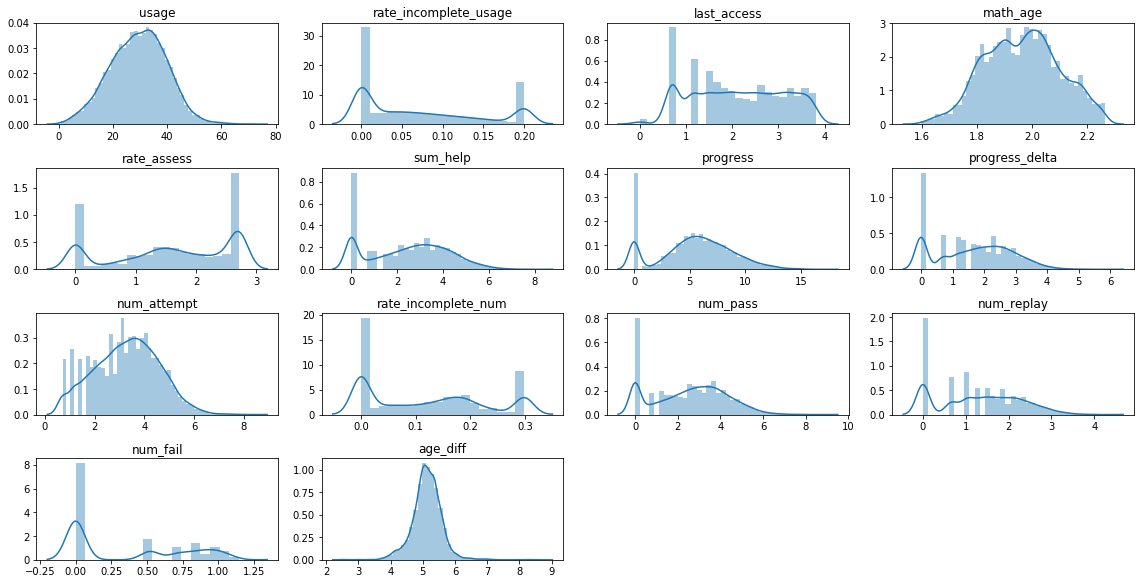

In [4]:
df_whizz1 = df_whizz.set_index(['customer_month'], append=True, inplace=False)
df_whizz1 = df_whizz.reset_index()
df_whizz1.set_index(['customer_month', 'pupilId'], inplace=True)

from scipy.stats import boxcox
import seaborn as sns
import mglearn

ftr_list = ['usage', 'usage_complete', 'usage_incomplete', 'rate_incomplete_usage',
            'last_access', 
            'age', 'math_age',
            'rate_assess', 'sum_help', 
            'progress', 'progress_delta',
            'num_attempt',  'num_complete', 'num_incomplete', 'rate_incomplete_num', 
            'num_pass', 'num_replay', 'num_fail',
            'holiday',
            'age_diff'
           ]
ftr_list = ['usage', 'rate_incomplete_usage',
            'last_access', 
            'math_age',
            'rate_assess', 'sum_help', 
            'progress', 'progress_delta',
            'num_attempt',  'rate_incomplete_num', 
            'num_pass', 'num_replay', 'num_fail',
            'age_diff'
           ]
ftr_list_nontransform = []

X = []
Xt = []

n_col = 4
n_ftr = len(ftr_list)
n_row = n_ftr // n_col
n_row +=  n_ftr % n_col
pos = range(1, n_ftr+1)

fig = plt.figure(figsize=(4*n_col,2*n_row))
for i, ftr in enumerate(ftr_list):
    ax = fig.add_subplot(n_row, n_col, pos[i])
    x = df_whizz1[ftr].values + 1
    
    if ftr in ftr_list_nontransform:
        sns.distplot(x)
        ax.set_title(ftr)
    else:
        if ftr == 'age_diff':
            x += 10
        xt,_ = boxcox(x)
        Xt.append(xt)
        sns.distplot(xt)
        ax.set_title(ftr)
        
    X.append(x)
plt.tight_layout()
    
X = np.array(X).transpose()
Xt = np.array(Xt).transpose()
y = df_whizz1.churn.values

## Gausian Mixture Model

Initialization 0
  Iteration 0	 time lapse 0.38747s	 ll change inf
  Iteration 10	 time lapse 1.10198s	 ll change 0.15048
  Iteration 20	 time lapse 1.12070s	 ll change 0.01347
  Iteration 30	 time lapse 1.17119s	 ll change 0.00202
  Iteration 40	 time lapse 1.16630s	 ll change 0.00216
  Iteration 50	 time lapse 1.13528s	 ll change 0.00034
  Iteration 60	 time lapse 1.17025s	 ll change 0.00009
  Iteration 70	 time lapse 1.26299s	 ll change 0.00063
  Iteration 80	 time lapse 1.24569s	 ll change 0.00031
  Iteration 90	 time lapse 1.37584s	 ll change 0.00003
  Iteration 100	 time lapse 1.15214s	 ll change 0.00028
  Iteration 110	 time lapse 1.17892s	 ll change 0.00009
  Iteration 120	 time lapse 1.17508s	 ll change 0.00008
  Iteration 130	 time lapse 1.16197s	 ll change 0.00011
  Iteration 140	 time lapse 1.17648s	 ll change 0.00032
  Iteration 150	 time lapse 1.15935s	 ll change 0.00009
  Iteration 160	 time lapse 1.23553s	 ll change 0.00010
  Iteration 170	 time lapse 1.17262s	 ll chang

  Iteration 160	 time lapse 1.21705s	 ll change 0.00001
  Iteration 170	 time lapse 1.18620s	 ll change 0.00000
Initialization converged: True	 time lapse 21.94150s	 ll 8.13006
Initialization 7
  Iteration 0	 time lapse 0.43383s	 ll change inf
  Iteration 10	 time lapse 1.20979s	 ll change 0.16855
  Iteration 20	 time lapse 1.38563s	 ll change 0.01670
  Iteration 30	 time lapse 1.35591s	 ll change 0.00583
  Iteration 40	 time lapse 1.56228s	 ll change 0.00058
  Iteration 50	 time lapse 1.59185s	 ll change 0.00034
  Iteration 60	 time lapse 1.88602s	 ll change 0.00032
  Iteration 70	 time lapse 1.21593s	 ll change 0.00028
  Iteration 80	 time lapse 1.19520s	 ll change 0.00023
  Iteration 90	 time lapse 1.23264s	 ll change 0.00001
Initialization converged: True	 time lapse 14.30735s	 ll 7.91908
Initialization 8
  Iteration 0	 time lapse 0.60170s	 ll change inf
  Iteration 10	 time lapse 1.23515s	 ll change 0.21948
  Iteration 20	 time lapse 1.24571s	 ll change 0.03262
  Iteration 30	 tim

<Container object of 15 artists>

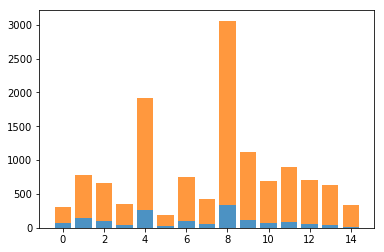

In [13]:
from sklearn import mixture

n_components = 15
n_features = len(ftr_list)

gmm = mixture.GaussianMixture(
    n_components=n_components, covariance_type='full', verbose=2, n_init=10, tol=1e-6, max_iter=1000).fit(Xt)

group = gmm.predict(Xt)
num_pupil = []
num_churn = []
for i in range(0,n_components):
    idx_pupils = np.where(group==i)[0]
    num_pupil.append(idx_pupils.shape[0])
    num_churn.append(y[idx_pupils].sum())
    
df_g = pd.DataFrame({'num_pupil':num_pupil, 'num_churn':num_churn})
df_g = df_g.assign(rate_churn=df_g.num_churn/df_g.num_pupil)
df_g.sort_values('rate_churn', ascending=False, inplace=True)

idx = np.arange(df_g.shape[0])
plt.bar(idx, df_g.num_churn, alpha=0.8)
plt.bar(idx, df_g.num_pupil-df_g.num_churn, bottom=df_g.num_churn, alpha=0.8)

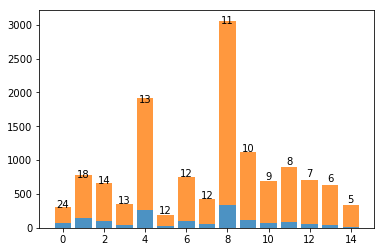

In [32]:
df_g = pd.DataFrame({'num_pupil':num_pupil, 'num_churn':num_churn})
df_g = df_g.assign(rate_churn=df_g.num_churn/df_g.num_pupil)
df_g.sort_values('rate_churn', ascending=False, inplace=True)

fig, ax = plt.subplots()
idx = np.arange(df_g.shape[0])
ax.bar(idx, df_g.num_churn, alpha=0.8)
rects = ax.bar(idx, df_g.num_pupil-df_g.num_churn, bottom=df_g.num_churn, alpha=0.8)

def autolabel(rects, values):
    """
    Attach a text label above each bar displaying its height
    """
    for rect, value in zip(rects, values):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.1*height,
                '%d' % int(value*100),
                ha='center', va='bottom')
autolabel(rects, df_g.rate_churn.values)

In [9]:
n_components = 20
bic = []

for k in range(1, n_components+1):
    gmm = mixture.GaussianMixture(
        n_components=k, covariance_type='full', verbose=0, n_init=1, tol=1e-6, max_iter=1000).fit(Xt)
    bic.append(gmm.bic(X))
    print('Number of components = {}'.format(k))

Number of components = 1
Number of components = 2
Number of components = 3
Number of components = 4
Number of components = 5
Number of components = 6
Number of components = 7
Number of components = 8
Number of components = 9
Number of components = 10
Number of components = 11
Number of components = 12
Number of components = 13
Number of components = 14
Number of components = 15
Number of components = 16
Number of components = 17
Number of components = 18
Number of components = 19
Number of components = 20


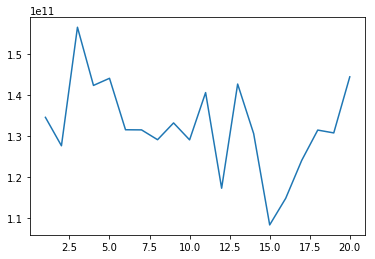

In [10]:
plt.plot(range(1, n_componentsponents+1), bic)

## Bayesian Gaussian Mixture Model

In [6]:
dpgmm = mixture.BayesianGaussianMixture(
    n_components=n_components, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(n_features),
    init_params="random", tol=1e-5, max_iter=10000, random_state=2, verbose=2).fit(Xt)

Initialization 0
  Iteration 0	 time lapse 0.05884s	 ll change inf
  Iteration 10	 time lapse 0.39139s	 ll change 12320.80649
  Iteration 20	 time lapse 0.38529s	 ll change 339.71730
  Iteration 30	 time lapse 0.48435s	 ll change 122.12524
  Iteration 40	 time lapse 0.45184s	 ll change 1.19832
  Iteration 50	 time lapse 0.40093s	 ll change 0.02989
  Iteration 60	 time lapse 0.42538s	 ll change 0.00439
  Iteration 70	 time lapse 0.40349s	 ll change 0.00119
  Iteration 80	 time lapse 0.42480s	 ll change 0.00032
  Iteration 90	 time lapse 0.40192s	 ll change 0.00007
  Iteration 100	 time lapse 0.39049s	 ll change 0.00001
Initialization converged: True	 time lapse 4.32044s	 ll 133383.78723


<Container object of 5 artists>

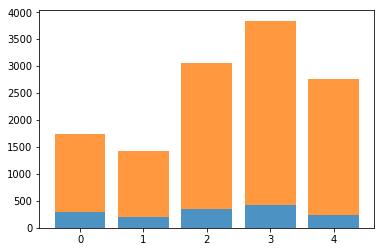

In [7]:
group = dpgmm.predict(Xt)
num_pupil = []
num_churn = []
for i in range(0,n_components):
    idx_pupils = np.where(group==i)[0]
    num_pupil.append(idx_pupils.shape[0])
    num_churn.append(y[idx_pupils].sum())
    
df_g = pd.DataFrame({'num_pupil':num_pupil, 'num_churn':num_churn})
df_g = df_g.assign(rate_churn=df_g.num_churn/df_g.num_pupil)
df_g.sort_values('rate_churn', ascending=False, inplace=True)

idx = np.arange(df_g.shape[0])
plt.bar(idx, df_g.num_churn, alpha=0.8)
plt.bar(idx, df_g.num_pupil-df_g.num_churn, bottom=df_g.num_churn, alpha=0.8)